# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from utils.rnn import (
    load_imdb_datasets,
    build_vocabulary,
    vectorize_text,
    data_generator,
    get_device,
    evaluate,
    train
)

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


The different functions from utils.rnn are in the file [rnn.py](./utils/rnn.py).

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
train_df, valid_df, test_df = load_imdb_datasets()

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


Train set size: 20000
Validation set size: 5000
Test set size: 25000


## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [3]:
tokenizer = get_tokenizer("basic_english")
vocabulary = build_vocabulary(dataset=train_df, tokenizer=tokenizer)

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [4]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [5]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  39, 4850,   11,  265,  646,    8,   27,   27,   27,    0])

In [6]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [7]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [8]:
device = get_device()

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [9]:
class RNN(nn.Module):
    """
    Custom RNN model.
    """
    def __init__(
        self,
        vocabulary_size: int,
        embedding_size: int,
        hidden_size: int,
        output_size: int,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialize the hidden state.
        Args:
            batch_size: the batch size.
        Returns:
            A tensor of zeros.
        """
        return torch.zeros(batch_size, self.hidden_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        Args:
            x (torch.Tensor): the input batched tensor.
        Returns:
            (torch.Tensor): The output batched tensor.
        """
        x = self.embedding(x)
        h = self.init_hidden(x.shape[0]).to(x.device)
        for i in range(x.shape[1]):
            h = self.tanh(self.W(x[:, i]) + self.U(h))
        return self.softmax(self.V(h))

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1/5 train loss: 0.025 valid loss: 0.026


0it [00:00, ?it/s]

Epoch 2/5 train loss: 0.025 valid loss: 0.025


0it [00:00, ?it/s]

Epoch 3/5 train loss: 0.025 valid loss: 0.026


0it [00:00, ?it/s]

Epoch 4/5 train loss: 0.025 valid loss: 0.026


0it [00:00, ?it/s]

Epoch 5/5 train loss: 0.025 valid loss: 0.026


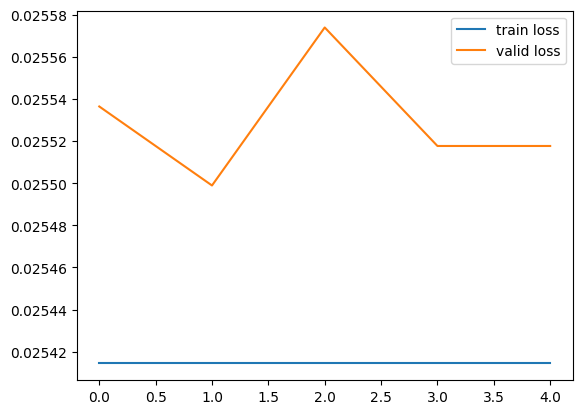

In [10]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# For the training, we need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.
# For each batch, we need to loop through the whole input and use the output of the last token as input for our criterion.
# Keep the best model evaluated on the validation set.adam

train_losses, valid_losses = train(
    model, X_train, X_valid, criterion, optimizer, train_gen, valid_gen, 5, device
)

# Plot the train and validation losses.
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [11]:
# Evaluate the model on the train set.
accuracy, precision, recall, f1 = evaluate(model, train_gen, device)

Accuracy: 0.500
Precision: 0.500
Recall: 1.000
F1-score: 0.667


In [12]:
# Evaluate the model on the validation set.
_ = evaluate(model, valid_gen, device)

Accuracy: 0.500
Precision: 0.500
Recall: 1.000
F1-score: 0.667


In [13]:
# Evaluate the model on the test set.
_ = evaluate(model, test_gen, device)

Accuracy: 0.500
Precision: 0.500
Recall: 1.000
F1-score: 0.667


Strangely enough, we have an isssue with the accuracy. As we can observe during the training, the loss remains approximately constant. Here, the testing results are also identical for all the datasets. Unfortunately, we could not find the reason for this issue ...